# Modèle de scoring - Partie 1 : Préparation du jeu de données

Construisons un modèle de scoring qui permettra à notre entreprise de calculer la probabilité qu’un client rembourse ou non son crédit à la consommation.

<img src="https://www.ionos.fr/digitalguide/fileadmin/DigitalGuide/Teaser/deep-learning-vs-machine-learning-t.jpg">

## Présentation du contexte

Nous évoluons en tant que Data Scientiste au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.

Notre entreprise souhaite développer un algorithme de scoring qui aidera les chargés de relation client, les utilisateurs finaux du modèle de scoring, à décider si un prêt peut être accordé au client ou non.

Les chargés de relation client souhaitent que le modèle soit facilement interprétable et qu'il dispose d’une mesure de l’importance des variables qui ont poussés le modèle à donner cette probabilité à un client.

Le modèle de scoring sera développé via l'entraînement d'algorithmes de classification supervisée.

Pour réaliser ce modèle, nous avons à disposition un jeu de données qui contient :
- un historique de prêts,
- un historique d’informations financières,
- les données de classification (TARGET) où la valeur 0 représente le remboursement du prêt dans les temps et la valeur 1 représente des difficultés de remboursement,
- des informations sur le comportement des emprunteurs (si l’emprunteur a fait défaut dans le passé ou non).
 
La construction du modèle de scorring se fera en deux parties :
- <b>Partie 1 : Préparation du jeu de données (ce document)
> Cette première partie sera consacrée à l'expploration générale, la définition d'une méthodologie d'annalyse, le nettoyage du jeu de données, au featurs Engenering à l'analyse multivariée du jeu de données et enfin notre conclusion apportera des éléments de réponse à savoir si l'analyse exploiratoire permet de déterminer le comportement général sur le remboursement des prêts banquaires.

- <b> Partie 2 : Construction du modèle de scoring
> Cette seconde partie sera consacrée à la sélection des modèles d'entrainement, la définission des métriques d'évaluation de la performance des modèles, la défnition d'une méthodologie permettant le calcul de l'importance des variables et enfin la création de variables qui permettrons l'amélioration de la prédiction.

Afin de réaliser ce projet, nous utiliserons le langage de programmation Python (version 3.8) et certaines des bibliothèques de datasciences qui seront répertoriées dans le fichier "requierment.txt".

<b>Attention </b> L'exécution de ce document nécessite le dossier 'Projet+Mise+en+prod+-+home-credit-default-risk' disponible à l'adresse : 
[ici](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)

## Exploration générale

Pour la construction du modèle de scoring, nous disposons d'un jeu de données réparti en 10 fichiers, voici la liste de ces fichiers accompagnés d'une description synthétique :
- 'application_train.csv' | Jeu de données principal contenant la cible (Target) du modèle de scoring, il contient les informations de base du client souscrivant au crédit.
- 'application_test.csv'| Jeu de données secondaire permetant de déterminer le score du modèle entraîné (Kaggle), il contient les mêmes information que le jeu de données précédent (sans target).
- 'bureau.csv' | Jeu de données relatif aux crédits antérieurs du client auprès d'autres institutions financières.
- 'bureau_balance.csv' | Données mensuelles sur les crédits précédents du client, chaque ligne correspondant à un mois.
- 'credit_card_balance.csv' | Données mensuelles sur les cartes de crédit précédentes que les clients.
- 'installments_payments.csv' | Historique des remboursements pour les prêts précédents accordés aux clients.
- 'POS_CASH_balance.csv' | Données mensuelles sur les points de vente et distributeurs que les clients ont consultés.
- 'previous_application.csv' | Données relatives aux précédentes demandes de crédit du client.
- 'HomeCredit_columns_description.csv' | Description des variables pour l'ensemble des fichiers cités précédemment.
- 'sample_submission.csv' | Fichier inexploitable.

Lors de cette exploration générale, nous observerons la répartition des variables présentes dans le fichier principal application_train.csv. Nous commençons dans un premier temps par importer le jeu de données afin de visualiser les variables (leurs types ainsi que leurs répartitions), et les dimensions des données contenues dans chaque fichier :

In [15]:
# Import des bibliothèque de datascience
import pandas as pd
import numpy as np
import seaborn as sns
import ipywidgets as widgets
from googletrans import Translator
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# Chemin du repertoir contenant les fichiers listés précédement
path = './Projet+Mise+en+prod+-+home-credit-default-risk/'


# Import du fichier : application_train.csv
with open(path + 'application_train.csv', encoding="utf8", errors='ignore') as f:
    application_train = pd.read_csv(f)
          
# Import du fichier : bureau.csv
with open(path + 'bureau.csv', encoding="utf8", errors='ignore') as f:
    bureau = pd.read_csv(f)
          
    
# Import du fichier : installments_payments.csv
with open(path + 'HomeCredit_columns_description.csv', encoding="utf8", errors='ignore') as f:
    df_info = pd.read_csv(f)    
          
# Import du fichier : previous_application.csv
with open(path + 'previous_application.csv', encoding="utf8", errors='ignore') as f:
    previous_application = pd.read_csv(f)
          
# Import du fichier : previous_application.csv
with open(path + 'HomeCredit_columns_description.csv', encoding="utf8", errors='ignore') as f:
    df_info = pd.read_csv(f)

# Synthèse des import dans la varaible d'environement df
df = [0, application_train, bureau,
      df_info, previous_application]

print('Données importées')

Données importées


In [2]:
from googletrans import Translator

translator = Translator()
def trad(x):
    return translator.translate(text=x, dest='fr',src='en').text

df_info['Descrition_Trad'] = df_info.Description.apply(lambda x: trad(x))

Sur l'ensemble des fichiers, un individu peut être décrit par 219 variables, toutes décrites dans le fichier 'HomeCredit_columns_description.csv'.

Par la suite nous décidons de nous consacrer à la n'analyse du fichier application_test.csv. Cette décision fait suite principale à l'observation de la taille des fichiers, 2.5Go au total. L'analyse et la construction du modèle ce fera donc sur ce fichier, nous utiliserons ponctuellement d'autre fichier pour la construction de variables notament le fichier 'bureau.csv' un jeu de données relatif aux crédits antérieurs du client auprès d'autres institutions financières, et le fichier 'HomeCredit_columns_description.csv' qui repertorie la description des variables pour l'ensemble des fichier.

Affichons les données de notre fichier principal application_train :

In [3]:
df[1]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Pour l'entraînement de notre modèle, nous disposons d'un échantillon de 307 511 individus (clients). Chaque client est décrit par 122 variables.

Nous observons sur le graphique ci-dessous la répartition du taux de valeurs manquantes pour les variables du fichier principal.
En moyenne, sur les 122 variables, le taux de valeur manquante est de 24,4%, les variables contenant le plus de valeurs manquantes étants les variables : 'COMMONAREA_AVG', 'COMMONAREA_MODE', 'COMMONAREA_MEDI' avec près de 70% de valeurs manquante.

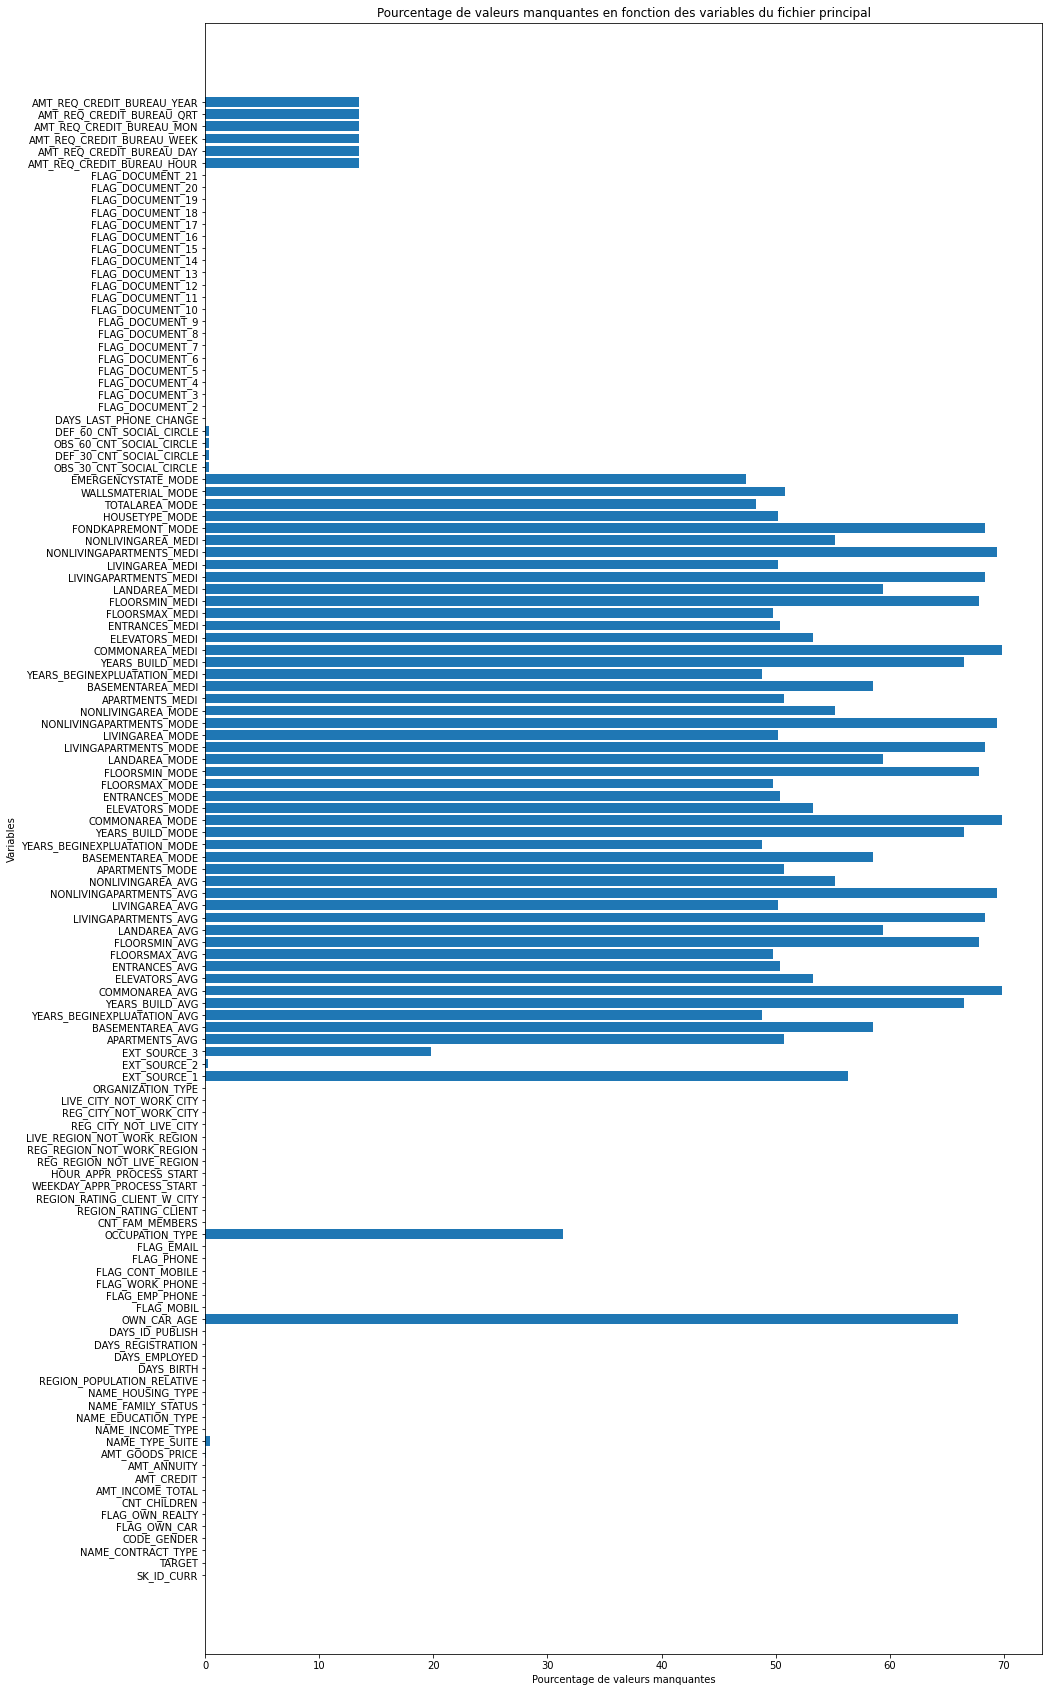

In [4]:
tot = len(df[1])
taux_na = []
for u in  df[1].columns:
    taux_na.append(df[1][u].isna().sum()/tot*100)
    
plt.figure(figsize=(15,30))
plt.title('Pourcentage de valeurs manquantes en fonction des variables du fichier principal')
plt.xlabel('Pourcentage de valeurs manquantes')
plt.ylabel('Variables')
plt.barh(df[1].columns,taux_na)
plt.show()

À noter que près de la moitié des variables (55 variables sur 122) ne possède aucune valeur manquante.

Nous appliquerons un filtre pour la sélection des variables afin de conserver uniquement les variables contenant moins de 24,4% de valeurs manquantes.

Concernant la constitution des variables, nous comptabilisons :
- 16 variables qualitatives
- 104 variables quantitatives

Nous affichons par la suite un affichage graphique de la répartition des variables en fonction de leur nature qualitatives ou quantitatives. Pour facilité la compréhension des agents un description de chaque variable est apportée ainsi que les éléments statistiques de cette variables.
> <b> Observation des variables qualitatives

In [5]:
v2 = df[1].describe(include=['object']).T.index

@widgets.interact(Variables = v2)
def produit_show(Variables):
    print(f'Description de la variable {Variables} : ', df_info[df_info.Row == Variables].Descrition_Trad.values[0])
    print(f'Description [ENg] de la variable {Variables} : ', df_info[df_info.Row == Variables].Description.values[0])

    print('Pourcentage de valeurs manquantes :',df[1][Variables].isna().sum()/tot*100,'%')
    
    print(f'Données statistique de la variable {Variables} :')
    print(df[1][Variables].describe())
    
    plt.figure(figsize=(15,10))
    plt.title(f'Répartition de la variable {Variables}')
    plt.pie(df[1][Variables].value_counts(),autopct='%1.2f%%')
    plt.legend(df[1][Variables].value_counts().index)
    plt.show()

interactive(children=(Dropdown(description='Variables', options=('NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OW…

> <b> Observation des variables quantitatives

In [6]:
v = df[1].describe(include=[float, int]).T.index[2:]

@widgets.interact(Variables = v)
def produit_show(Variables):
    print(f'Description de la variable {Variables} : ', df_info[df_info.Row == Variables].Descrition_Trad.values[0])
    print('Pourcentage de valeurs manquantes :',df[1][Variables].isna().sum()/tot*100,'%')
    
    print(f'Données statistique de la variable {Variables} :')
    print(df[1][Variables].describe())
    
    plt.figure(figsize=(15,5))
    plt.title(f'Boite à moustache de la variable {Variables}')
    sns.boxenplot(y = Variables, x= 'TARGET',data = df[1])
    plt.show()  

interactive(children=(Dropdown(description='Variables', options=('CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CRED…

L'observation de la répartion des variable numérique nous montre que pour certaine répartition, telque pour la variable AMT_INCOME_TOTAL, qui représente les revenus anuelle d'un client, certaines valeurs sont très significativement éloignées de l'ensemble des données, en effet pour cette exemple le point extrème se trouve à 120 million de revenu annuel ce qui n'est pas impossible mais qui est 800 fois la valeur moyenne. Il sera donc nécessaire d'encadrer les valeurs que nous jugeons ne pas être des valeurs aberrantes.

## Méthodologie

Cette première phase d'observation nous permet de définir la méthodologie que nous appliquerons pour notre nettoyage du jeu de données, notre méthode de sélection/création de variable, mais également pour notre analyse approfondie du jeu de donnée.

A l'issue de ce document consacré pour rappel à l'analyse exploratoire, nous fournirons un jeu de données nettoyé et près à être utilisé pour l'entraînement de nos modèles.

<b> Méthodologie de nettoyage du jeu de données </b> 
- Nous commencerons notre nettoyage par la sélection des variables possédant moins de 24,4% de valeurs manquantes, ce taux correspond au taux moyen de valeurs manquantes pour le jeu de données du fichier principal.
- Nous traiterons les valeurs dupliquées, c'est-à-dire les individus qui apparaissent plusieurs fois dans le jeu de données.
- Nous procéderons ensuite par l'exclusion des valeurs aberrantes via le calcul de l'espace interquartil, on définira ainsi une valeur aberrante comme étant en-dehors de cet interval.
- Ensuite, nous remplacerons les valeurs manquantes par la médiane des variables et en fonction de la Target(0 ou 1) pour les variables quantitatives.
- Nous supprimerons du jeu de données les individus possédant plus 50% d'information manquante.
- Enfin, nous supprimerons les individus possédant des informations manquantes pour les variables qualitatives.

<b> Méthodologie de feature Egenrie </b> 
- Nous remplacerons dans un premier temps les variables qualitatives par des valeurs numériques qui pourront être interprétées par notre modèle de scoring.
- Création de la variable : AMT_ANNUITY_SUM, qui représente la somme des rentes des précédents prêts accordés au client
- Création de la variable : AMT_DOWN_PAYMENT_SUM, qui correspond à la somme des acomptes pour les prêts antérieur du client.
- Création de la variable : NB_DIR, qui correspond au nombre de prêt antérieur possé par le client.

<b> Méthodologie d'analyse exploratoire </b> 
- Notre analyse exploratoire approfondie débutera avec l'observation de la variable Target, de manière uni varié et multivariée.
- Nous observerons ensuite la répartion des variables crées lors dans une analyse multivariée.
- Nous chercherons pour finir les corrélations entre variables.
- Nous conclurons enfin pour savoir si cette analyse permet connaitre la typologie des clients susceptible de faire défaut.

# Traitement du jeu de données

## Datacleaning


Conformément à la méthodologie mise en place, nous procédons au filtrage des variables ayant un taux de valeurs manquantes supérieur à 24,4%, pour rappelle ce taux correspond au taux moyen de valeurs manquantes sur l'ensemble des 122 variables.

In [7]:
# Suppression des variales en fonction du taux de valeures manquantes
taux_na = np.array(taux_na)

# filtrage des variables ayant un taux suppérieur à 24,4% de valeures manquantes
col = df[1].columns[taux_na < taux_na.mean()]
application_train = df[1][col]

D'après nos observations, le jeu de donnés ne contient pas de valeurs dupliquées.

In [8]:
df[1].duplicated().sum()

0

A noté que nous pourrions pousser notre definission d'une valeur dupliquée à un pourcentage d'information identique entre deux variables, cette méthode nécéciterait de définir un seuille à partir du quelle une valeur serait défini comme dupliquée. Cette méthode n'est pas retenu compte tenu de la taille du fichier et la puissance de caclul disponible, mais ceci sera à envisager lorsque nous aurons un modèle de scoring efficace et que nous chercherons à améliorer ces performances.

Nous nettoyons à présent les variables aberrantes, c'est-à-dire selon notre définition, les valeurs étant en dehors de l'espace interquartille définie pour chaque variable quantitatives continue.

In [9]:
# Definission de la fonction de nettoyage
def nettoyage(x):
    if x > limite and limite != 0:
        return 'Delete'
    else : return x

#Sélection des variables quantitatives continues
app_index = application_train.describe(include=[float]).T.index

# Definition de l'espace interquartille et nettoyage des données
for u in app_index:
    Espace_interquartil = application_train[u].quantile(.75) - application_train[u].quantile(.25)
    limite = application_train[u].quantile(.9) + 1.5 * Espace_interquartil
    
    application_train[u] = application_train[u].apply(lambda x: nettoyage(x))
    
    application_train = application_train[application_train[u] != 'Delete']

Nous remplaçons aprésent les variables manquantes.
Pour cela, nous créons en fonction des variables plusieurs groupes d'individus en fonction :
- du genre (Massculin ou Féminin)
- du type d'organisation auquel le client appartient ('School', 'Bank', 'Restauration',...) il y a en tout 58 groupes,
- de la décision relative au prêt (dificulté de rembouresment ou non)

Pour chaque variable, nous comptabilisons 232 groupes d'individus. Lorsque qu'une valeur est manquante, nous lui attribuons la valeur moyenne de la variable concernée.

In [10]:
# Sélection des variables quantitatives continue possédant des valeurs manquantes
app_index = application_train.describe(include=[float]).T['count'][application_train.describe(include=[float]).T['count'] != 307511.0].index

# Deffinission des goupes d'organisation, de genre et de prêt.
organization = application_train.ORGANIZATION_TYPE.unique()
genres = application_train.CODE_GENDER.unique()
Target = application_train.TARGET.unique()

# Deffinition de la fonction d'imputation par la moyenne
def replace(x):
    return mean_

application_train.NAME_TYPE_SUITE[application_train.NAME_TYPE_SUITE.isna()] = 'Unaccompanied'

# Imputaton par la moyenne en fonction des groupes
for variable in app_index:
    for mode in organization:
        for genre in genres:
            for y in Target :
                mean_= application_train[
                    (application_train[variable].notna()) &
                    (application_train.ORGANIZATION_TYPE == mode) &
                    (application_train.CODE_GENDER == genre) &
                    (application_train.TARGET == y)
                ][variable].mean()
            
                application_train[variable].loc[
                    (application_train[variable].isna()) &
                    (application_train.ORGANIZATION_TYPE == mode) &
                    (application_train.CODE_GENDER == genre) &
                    (application_train.TARGET == y)
                ] = application_train[variable].loc[
                    (application_train[variable].isna()) &
                    (application_train.ORGANIZATION_TYPE == mode) &
                    (application_train.CODE_GENDER == genre) &
                    (application_train.TARGET == y)
                ].apply(lambda x: replace(x))

A noter que cette méthode à ces limites, en effet remplacer les valeurs manquantes par la moyenne ou la médiane peut changer l'allure de la répartition de la variable. En effet cette méthode est adapter pour des distribution gaussienne et dans notre cas un remplacement en utilisant les voisins les plus proche aurait également été une très bonne alternative.

Pour finir, nous supprimons les individus ayant des valeurs manquantes pour les données catégorielles ou quantitatives discrètes.

In [11]:
# Suppression des valeurs manquante
for u in application_train.describe().T[application_train.describe().T['count'] != len(application_train)].index:
    application_train = application_train[application_train[u].notna()]

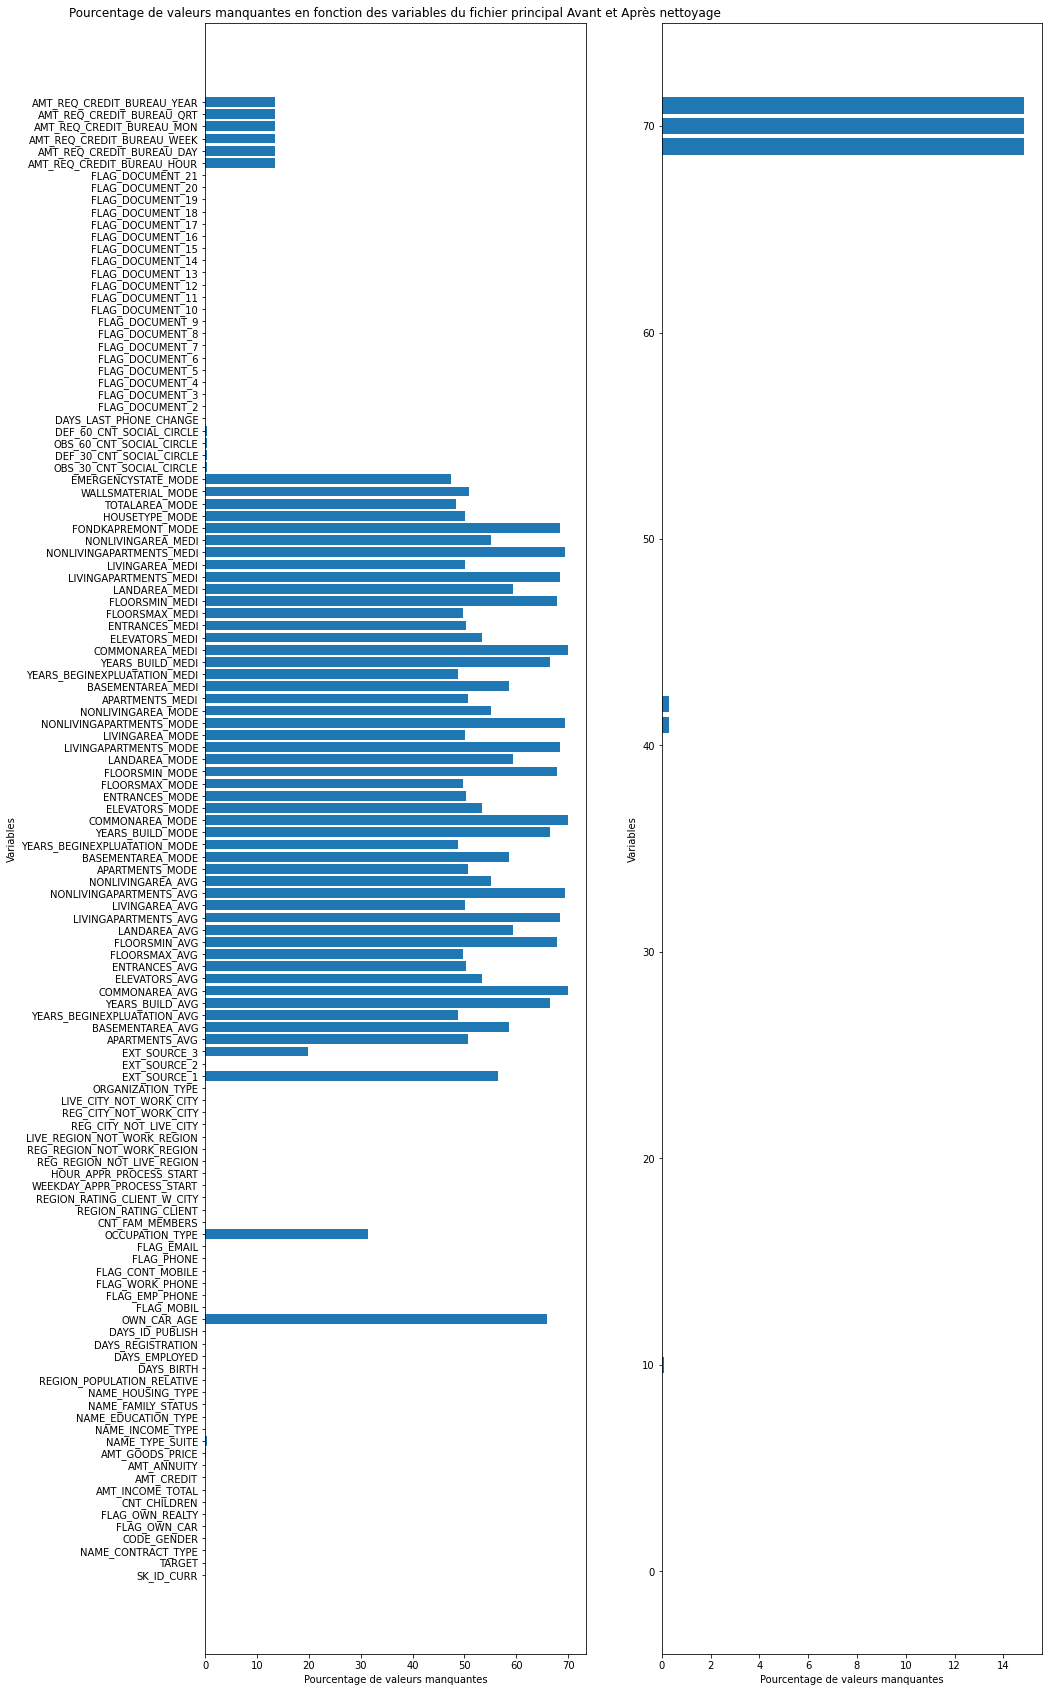

In [14]:
tot = len(application_train)
taux_na1 = []
for u in  application_train.columns:
    taux_na1.append(application_train[u].isna().sum()/tot*100)

plt.figure(figsize=(15,30))
plt.subplot(1, 2, 1)
plt.title('Pourcentage de valeurs manquantes en fonction des variables du fichier principal Avant et Après nettoyage')
plt.xlabel('Pourcentage de valeurs manquantes')
plt.ylabel('Variables')
plt.barh(df[1].columns,taux_na)


plt.subplot(1, 2, 2)
plt.xlabel('Pourcentage de valeurs manquantes')
plt.ylabel('Variables')
plt.barh(range(len(application_train.columns)),taux_na1)
plt.show()

Nous affichons à nouveau le taux de valeur manquante par variable. Nous constatons que le nettoyage a bien été réalisé.
Nous comptabilisons à présent :
- 23 variables quantitatives (x continue, y discrète)
- variables qualitatives (x ordinal, y catégoriel)
Soit Z variables décrivant notre jeu de données

Nous affichons par la suite un comparatif entre les différentes variables avant et après le nettoyage.

In [13]:
v = application_train.describe(include=[float]).T.index[2:]

@widgets.interact(Variables = v)
def produit_show(Variables):
    print(f'Description de la variable {Variables} : ', df_info[df_info.Row == Variables].Descrition_Trad.values[0])
    print('Pourcentage de valeurs manquantes :',application_train[Variables].isna().sum()/tot*100,'%')
    
    
    plt.figure(figsize=(15,5))
    plt.title(f'Boite à moustache de la variable {Variables} avant nettoyage du jeu de données')
    sns.boxenplot(y = Variables, x= 'TARGET',data = df[1])
    plt.show()
    
    plt.figure(figsize=(15,5))
    plt.title(f'Boite à moustache de la variable {Variables} après nettoyage du jeu de donnée')
    sns.boxenplot(y = Variables, x= 'TARGET',data = application_train)
    plt.show()
    
    print(f'Données statistique de la variable {Variables} :')
    print(application_train[Variables].describe())

interactive(children=(Dropdown(description='Variables', options=('EXT_SOURCE_3', 'OBS_60_CNT_SOCIAL_CIRCLE', '…

Après netoyage le jeu de donnée contient 193678 indivis et 72 variables contre 307 511 individu et 122 variable auparavant.


## Feature engineering

Comme énoncé dans notre méthodologie, nous appliquerons du features engineering qui servira à notre modèle de scoring.

Nous commençons par remplacer les variables qualitatives par des valeurs numériques. Notre modèle de scoring ne prend en effet en compte uniquement des valeurs numériques.

In [14]:
# Impor de la méthode LabelEncoder
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()

# Sélection des variables qualitatives
index_quali = application_train.describe(include='object').columns

data = application_train
# Remplacement des valeurs qualitative par des valeurs numériques
for col in index_quali:
    data[col] = labelencoder.fit_transform(application_train[col])

A noter également qu'il y a d'autres méthode pour encoder nos variables :
- La possibillité de créer de nouvelles collone dans notre jeu de données qui correspondront à chaque classe d'une varaible qualitatve
- La possibilité de relevé les classes les plus présentes d'une variable et indiquer 1 si l'individu en fait parti ou 0 s'il n'en fait pas parti.

Ces différentes méthode palient au faite que le modèle peut interpréter qu'une variable encodée pourait avoir une hiérarchie dans ces classes, ce qui n'est pas forcément le cas.
Nous n'avons pas choisi d'appliquer ces méthode pour l'heure car nous craignons qu'ajouter des variables allourdirons le jeu de donnée et augmentra le temps d'entrainement du modèle. Nous envisagerons d'améliorer les performance du modèle avec ces possibilité de feature engineering.

Nous créons à présent 3 variables :
- La variable : AMT_ANNUITY_SUM, qui représente la somme des rentes des précédents prêts accordés au client
- La variable : AMT_DOWN_PAYMENT_SUM, qui représente la somme de prêts accordés précédemment au client
- La variable : NB_DIR, qui représente le nombre de prêts accordé au client dans le passé.

Pour la création de ces nouvelles variables, nous utiliserons le fichier 'previous_application.csv' qui détient les données nécessaires.
Pour faire correspondre les deux jeux de données, nous utiliserons l'identifiants 'SK_ID_CURR' qui correspond à l'identifient d'un client. Dans le fichier 'previous_application.csv' les prêts sont identifiés par la variable 'SK_ID_PREV' de sorte que plusieurs prêts peuvent avoir le même identifiant client.

In [15]:
# Liste des identifiants client dans les deux jeux de données.
a = previous_application.SK_ID_CURR.unique()
b = application_train.SK_ID_CURR.unique()

# Création de La variables NB_DIR
NB_DIR = []
for u in b:
    NB_DIR.append(len(previous_application[previous_application.SK_ID_CURR == u]))
    
# Création de La variables AMT_ANNUITY_SUM
AMT_ANNUITY_SUM = []
for u in b:
    AMT_ANNUITY_SUM.append(previous_application[previous_application.SK_ID_CURR == u].AMT_ANNUITY.sum())


# Création de La variables AMT_DOWN_PAYMENT_SUM
AMT_DOWN_PAYMENT_SUM = []
for u in b:
    AMT_DOWN_PAYMENT_SUM.append(previous_application[previous_application.SK_ID_CURR == u].AMT_DOWN_PAYMENT.sum())
    
# Création d'un dataFrame contenant les trois variable rangées par l'ID  'SK_ID_CURR' 
new_var = np.array([b,NB_DIR,AMT_ANNUITY_SUM,AMT_DOWN_PAYMENT_SUM])
data_new = pd.DataFrame(new_var.T,columns=['SK_ID_CURR','NB_DIR','AMT_ANNUITY_SUM','AMT_DOWN_PAYMENT_SUM'])

# Fusion des dataFrame par merge de l'ID 'SK_ID_CURR'
data = data.merge(data_new,how='outer')

data['DAYS_BIRTH'] = data.DAYS_BIRTH//-365

Enfin, nous appliquons une normalisation des données puis nous transformons notre jeu de données dans un vecteur nommé X contenant l'ensemble des données numériques auquel nous retranchons la cible (Target), celle-ci sera affectée dans un vecteur y.

In [ ]:
# Import de la méthode StandardScaler pour la normalisation des données
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Definition de la varialbe X,y et normalisation des données
X = scaler.fit_transform(application_train.drop(['TARGET', 'SK_ID_CURR'], axis=1).values)
y = application_train.TARGET

Nous avons procédé au nettoyage et à la création/modification des variables de notre jeu de données en vue de créer notre modèle de scoring. Par la suite, nous explorerons plus en profondeur la répartition de notre jeu de donnée dans le but d'observer la répartition de nos variables et les relations existantes entre elles.

In [17]:
#data = application_train
pd.DataFrame.to_csv(data,'data.csv')

# Analyse exploratoire du jeu de données

Dans cette partie, après avoir nettoyer le jeu de données, nous allons observer la répartion de nos variables, l'objectif étant d'analyser le comportement de celles-ci en fonction de la target. Nous souhaitons observer s'il y a des différences visibles entre les individus ayant remboursé complètement leur crédit et ceux ayant eu des difficutlés.

Pour cela dans un premier temps nous observerons la variables 'Target', notament ses proportions, sa répartion en fonction du genre des individues, en fonction de l'age et du rapport entre le crédit demandé et les revenue annuels.

Pour rappel voici la liste des variables :

In [18]:
variables = df_info.Row.values
@widgets.interact(Variables = variables)
def produit_show(Variables):
    print(f'Description de la variable {Variables} : ', df_info[df_info.Row == Variables].Descrition_Trad.values[0])
    if Variables in application_train.columns:
        print('Pourcentage de valeurs manquantes :',application_train[Variables].isna().sum()/tot*100,'%')

interactive(children=(Dropdown(description='Variables', options=('SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE',…

In [93]:
data = pd.read_csv('data.csv',encoding="utf8")
print('Import successfully')

Import successfully


## Observation de la Variable cible - (Target)

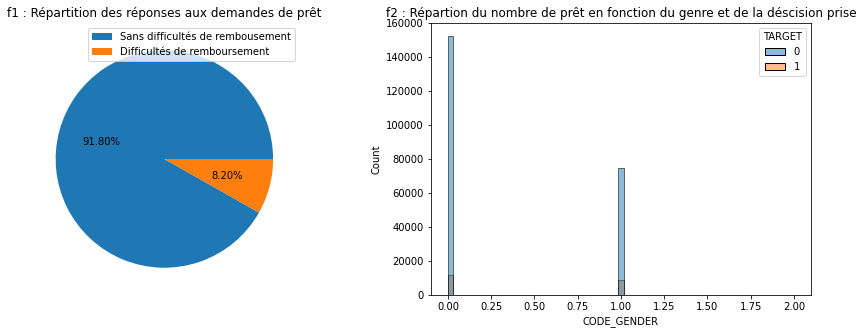

In [19]:
F1 = data[data.TARGET == 1].CODE_GENDER.value_counts()[0]/data.CODE_GENDER.value_counts()[0]*100
M1 = data[data.TARGET == 1].CODE_GENDER.value_counts()[1]/data.CODE_GENDER.value_counts()[1]*100

F0 = data[data.TARGET == 0].CODE_GENDER.value_counts()[0]/data.CODE_GENDER.value_counts()[0]*100
M0 = data[data.TARGET == 0].CODE_GENDER.value_counts()[1]/data.CODE_GENDER.value_counts()[1]*100

# affichage du camembert de Target
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title('f1 : Répartition des réponses aux demandes de prêt')
plt.pie(data.TARGET.value_counts(),autopct='%1.2f%%')
plt.legend(['Sans difficultés de rembousement', 'Difficultés de remboursement'])


plt.subplot(1, 2, 2)
plt.title('f2 : Répartion du nombre de prêt en fonction du genre et de la déscision prise')
sns.histplot(x = 'CODE_GENDER', hue = 'TARGET', data = application_train)
plt.show()

Comme le montre la figure 1, près de 92% des prêts ont été remboursés sans dificultés, soit 226 937 prêts contre 20 276 cas comportant des difficultés de remboursement. Cette observation nous permettra d'adapter l'entraînement de nombre modèle de scoring car il y a une différence très significative entre nos deux classes cibles.

La figure 2 nous montre la répartition des demandes en fonction du genre de l'individu, on constate qu'il y près de 66% des demandes de prêt ont été réalisées par des femmes contre 34% par des femmes. Selon les données observées, les prêts chez les femmes sont remboursés sans difficulté à 93% et environ 90% chez les hommes.

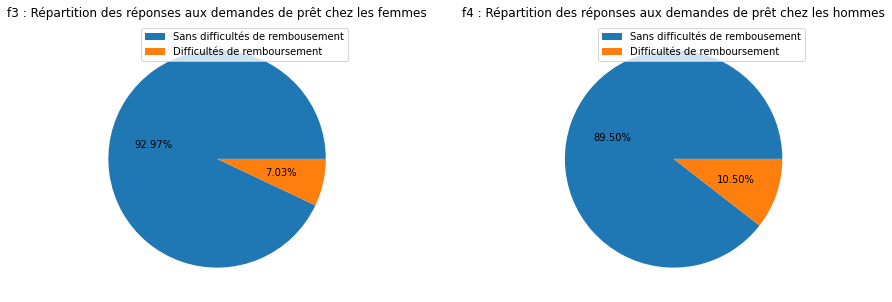

In [101]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title('f3 : Répartition des réponses aux demandes de prêt chez les femmes')
plt.pie([F0,F1],autopct='%1.2f%%')
plt.legend(['Sans difficultés de rembousement', 'Difficultés de remboursement'])

plt.subplot(1, 2, 2)
plt.title('f4 : Répartition des réponses aux demandes de prêt chez les hommes')
plt.pie([M0,M1],autopct='%1.2f%%')
plt.legend(['Sans difficultés de rembousement', 'Difficultés de remboursement'])
plt.show()

Sur les figure 3 et 4, nous observons les conditions de rembouserment chez les Hommes et chez les Femmes, Nous observons que chez les femmes, d'après nos données, le taux de remboursement sans dificulté est plus important, près de 93% contre 89,5 chez les hommes.

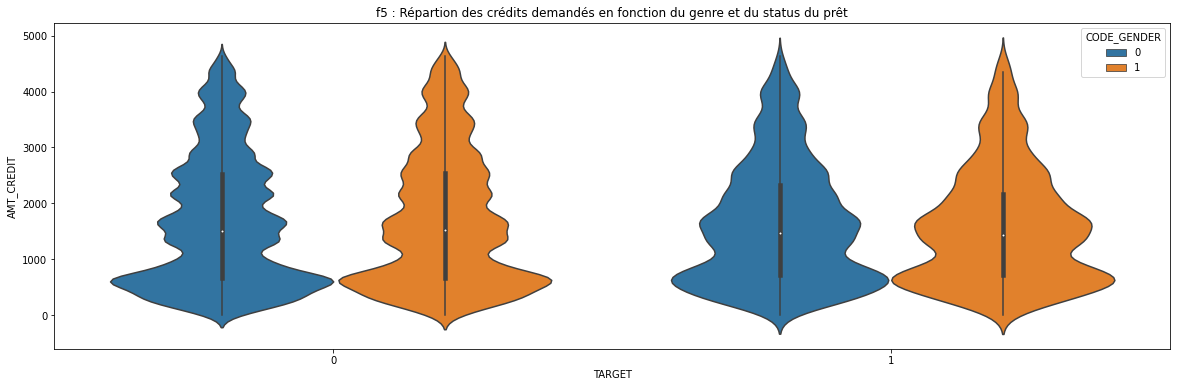

In [105]:
plt.figure(figsize=(20,6))
plt.title('f5 : Répartion des crédits demandés en fonction du genre et du status du prêt')
sns.violinplot(x = 'TARGET', y = 'AMT_CREDIT', data = data, hue='CODE_GENDER')
plt.show()

La figure 5 nous montre qu'en fonction du genre et de la variable cible il n'y a pas d'écart dans la répartition des prêts accordés.

De même la figure 6, qui affiche la répartition du rapport entre la montant du crédit accordé et le montant des revenus annuelles en fonction du genre et de la variable cible, ne nous montre pas de répartition différente.
On observe toutefois que les individus ont tendance à prendre des crédits s'élevant entre 2 et 10 fois leur revenu annuel.

Le remboursement ne semble pas dépendre du genre, du montant accordé ou des revenus annuels.

## Observation des variables : 'âges', 'statut social' et 'montant du crédit'

Dans cette partie, nous observerons la répartition des crédits accordés en fonction de l'âge du client, de sa situation familiale ainsi que de sa situation sociale.

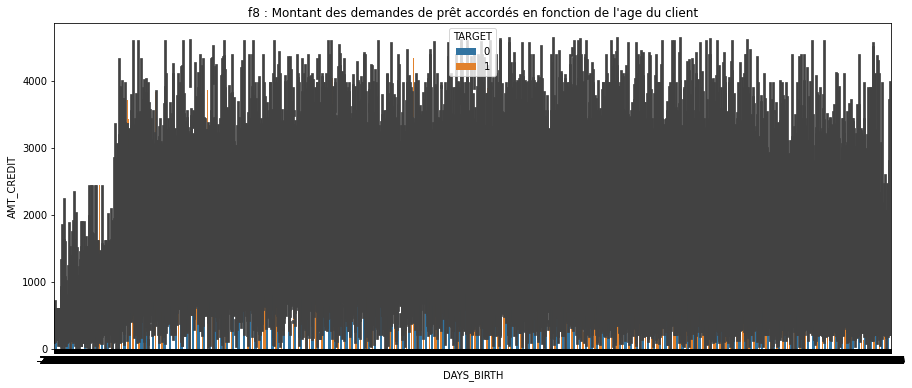

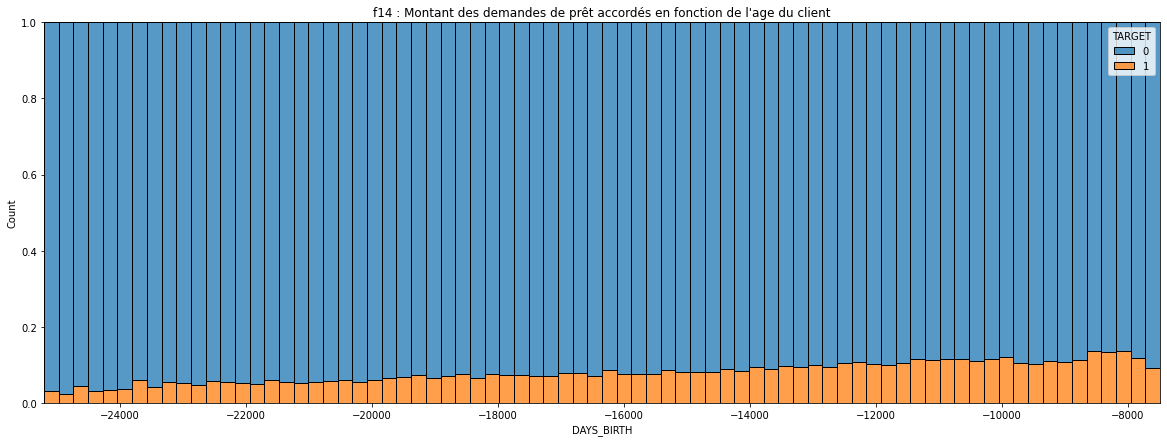

In [20]:
plt.figure(figsize=(15,6))
plt.title("f8 : Montant des demandes de prêt accordés en fonction de l'age du client")
sns.barplot(x = 'DAYS_BIRTH', y = 'AMT_CREDIT', data = application_train,hue='TARGET')
plt.show()

plt.figure(figsize=(20,7))
plt.title("f14 : Montant des demandes de prêt accordés en fonction de l'age du client")
sns.histplot(x = 'DAYS_BIRTH',data = application_train,hue='TARGET', multiple="fill")
plt.show()

Nous observons sur la figure 8 les crédits accordés en fonction de l'âge des clients, à l'âge de 45 ans les clients ont tendance à solliciter des prêts les plus élevés, tandis qu'avant 21 ans et après 64 ans les clients ont tendance à solliciter des montant 1/3 moins élevé par rapport à l'âge de 45 ans. De manière générale entre 25 et 52 ans les clients de la banque 'Home service' qui n'ont eu des difficultés de paiement sollicitaient des prêts 10% moins élevé que les clients n'ayant aucune difficulté. À partir de 62 ans, ce rapport s'inverse.

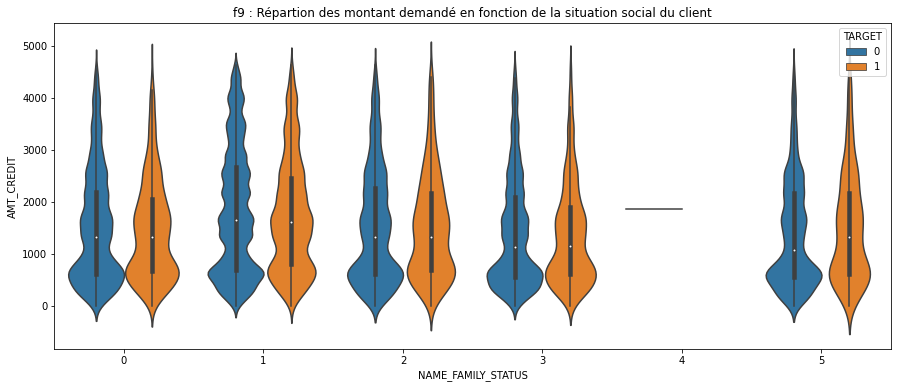

In [115]:
plt.figure(figsize=(15,6))
plt.title('f9 : Répartion des montant demandé en fonction de la situation social du client')
sns.violinplot(x = 'NAME_FAMILY_STATUS', y = 'AMT_CREDIT', data = application_train, hue='TARGET')
plt.show()

Sur la figure 9, nous voyons la distribution des crédits en fonction des situations familiale. Nous n'observons pas de distinctions en terme de montant demandé ou de difficulté de remboursement.

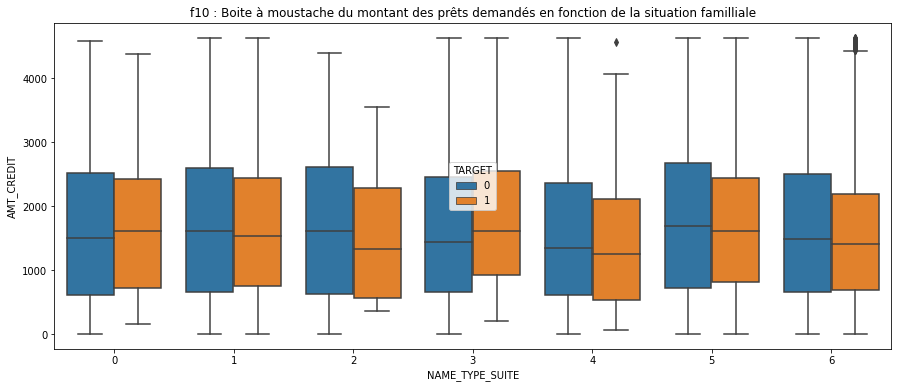

In [116]:
plt.figure(figsize=(15,6))
plt.title('f10 : Boite à moustache du montant des prêts demandés en fonction de la situation familliale')
sns.boxplot(x = 'NAME_TYPE_SUITE', y = 'AMT_CREDIT', data = application_train, hue='TARGET')
plt.show()

Enfin sur la figure 10, nous observons en fonction de la situation sociale les boites à moustache des prêts sollicités. En moyenne, quel que soit le groupe social, les crédits sollicités sont de 500 000€.

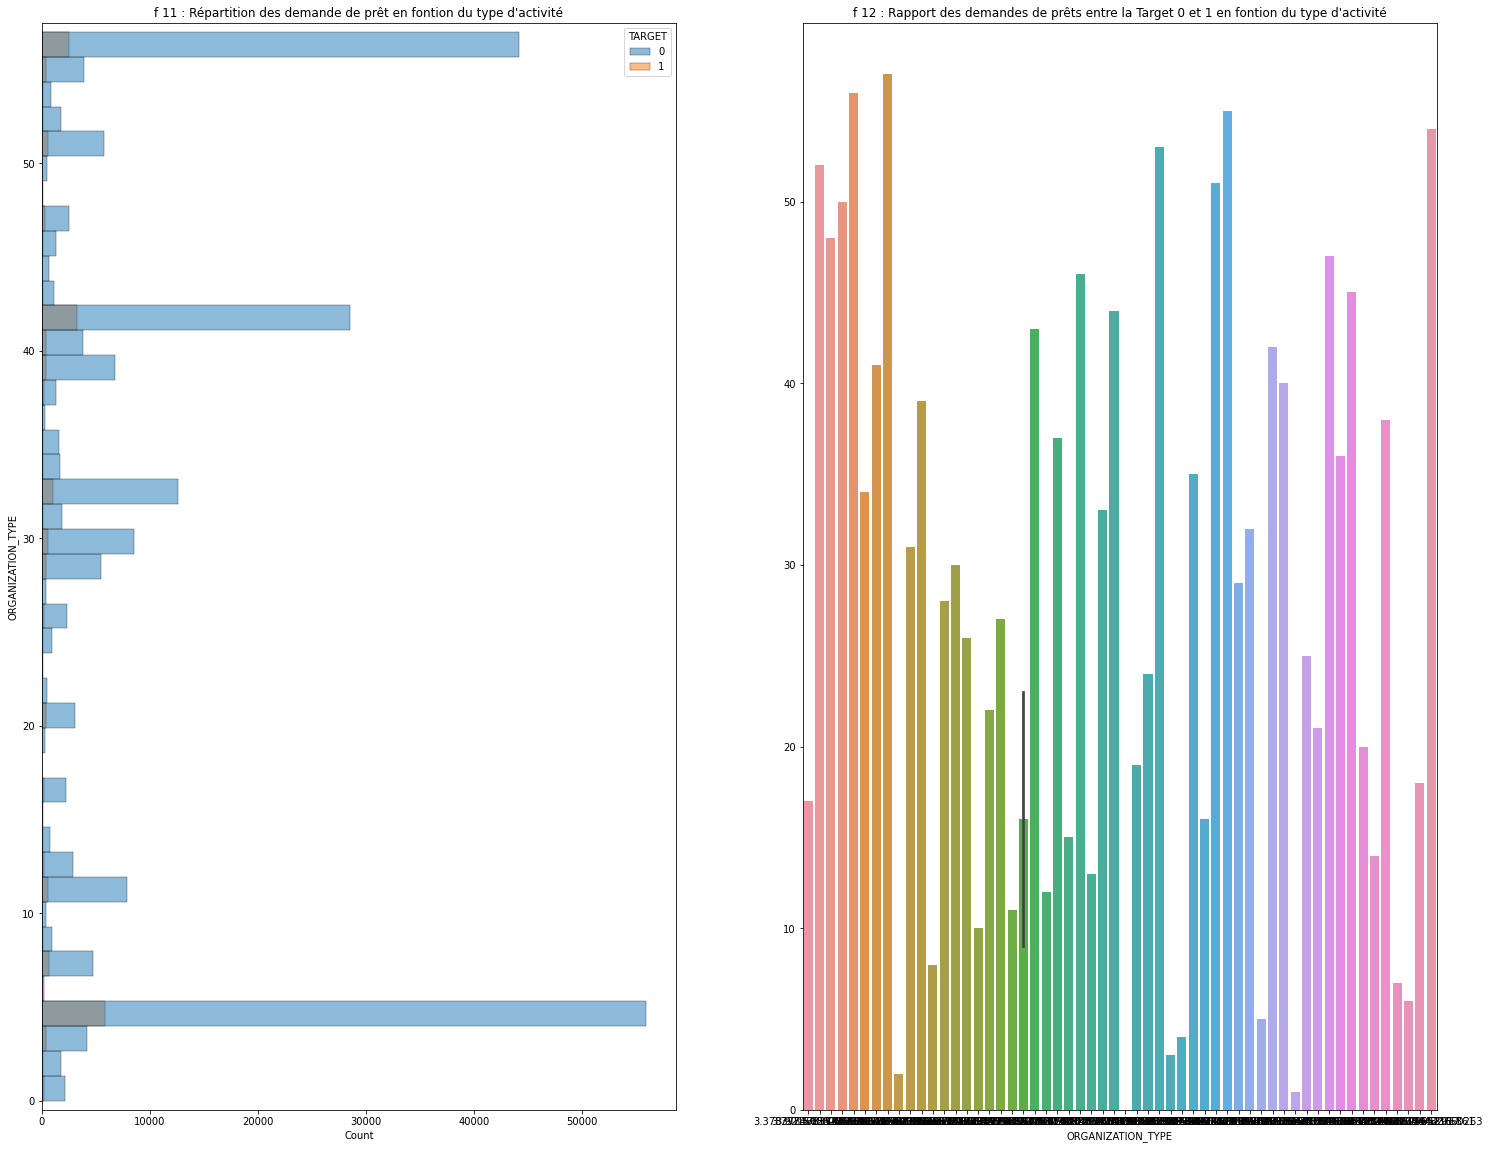

In [33]:
plt.figure(figsize=(25,20))
plt.subplot(1, 2, 1)
plt.title("f 11 : Répartition des demande de prêt en fontion du type d'activité")
plt.ylim(-0.5,57.5)
sns.histplot(y = 'ORGANIZATION_TYPE', data = data.sort_values(by=['ORGANIZATION_TYPE']), 
             hue='TARGET',linewidth=.3)

plt.subplot(1, 2, 2)
plt.title("f 12 : Rapport des demandes de prêts entre la Target 0 et 1 en fontion du type d'activité")
sns.barplot(x=data.ORGANIZATION_TYPE[data.TARGET == 1].value_counts().sort_index()/data.ORGANIZATION_TYPE.value_counts().sort_index()*100,y=data.ORGANIZATION_TYPE.value_counts().sort_index().index)
plt.show()

La figure 11 affiche le nombre de crédits sollicité en fonction du type d'emploi du client et de la cible, le type d'emploi le plus présent dans le jeu de donnée est 'Business Entytie de type 3', le graphique 12 nous montre la proportion entre le nombre de prêts remboursé et le nombre de prêts ayant des difficultés de remboursement en fonction du type d'emploi du client. Les rapports s'étalent entre 5 et 18% avec un pic pour l'activité 'Transport de Type 4 ce qui signifie qu'un client appartenant à ce type de métier a la probabilité la plus grande de faire défaut par rapport aux autres métiers, selon le jeu de données.


<b>Conclusion
    
Ces analyses nous révèlent le comportement des clients vis-à-vis du remboursement des prêts. Il semble que le montant sollicité en fonction de l'âge, le type de métier et dans une moindre mesure le genre du client influence sa capacité à rembourser le crédit sollicité.

## Observation à partir des variables créées

Dans cette partie nous observons les variables créées précédement :
- La variable : AMT_ANNUITY_SUM, qui représente la somme des rentes des précédents prêts accordés au client
- La variable : AMT_DOWN_PAYMENT_SUM, qui représente la somme de prêts accordés précédemment au client
- La variable : NB_DIR, qui représente le nombre de prêts accordé au client dans le passé.

> <b> Variable : NB_DIR

C:\Users\micke\AppData\Local\Temp/ipykernel_13608/3963679515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  application_train[u] = application_train[u].apply(lambda x: nettoyage(x))


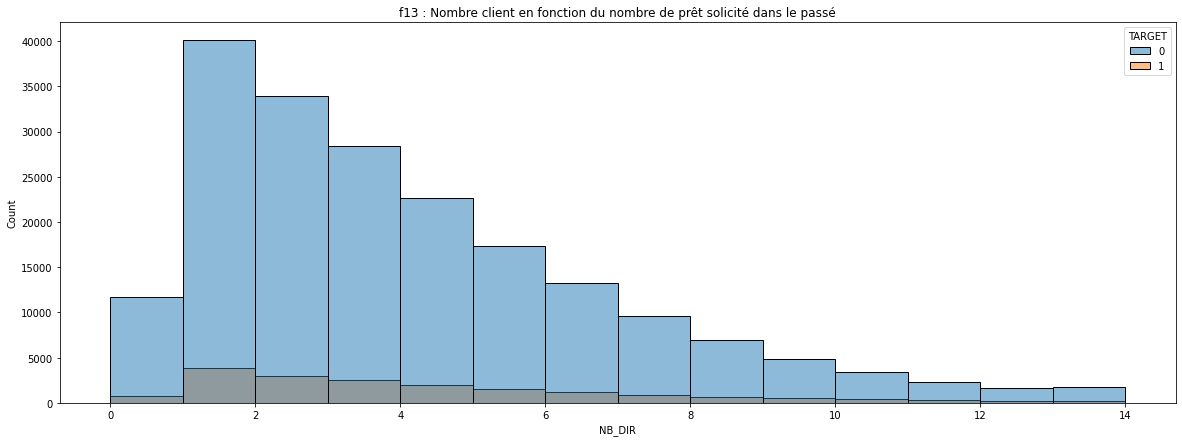

In [169]:
created_var = ['AMT_ANNUITY_SUM','AMT_DOWN_PAYMENT_SUM','NB_DIR']
for u in created_var:
    Espace_interquartil = application_train[u].quantile(.75) - application_train[u].quantile(.25)
    limite = application_train[u].quantile(.9) + 1.5 * Espace_interquartil
    
    application_train[u] = application_train[u].apply(lambda x: nettoyage(x))
    
    application_train = application_train[application_train[u] != 'Delete']

#data[['NB_DIR','AMT_ANNUITY_SUM','AMT_DOWN_PAYMENT_SUM']] = application_train[['NB_DIR','AMT_ANNUITY_SUM','AMT_DOWN_PAYMENT_SUM']]
plt.figure(figsize=(20,7))
plt.title("f13 : Nombre client en fonction du nombre de prêt solicité dans le passé")
sns.histplot(x = 'NB_DIR',data = application_train,hue='TARGET',bins=14)
plt.show()

Les figures 13 et 14 nous présente le nombre de crédits demandé par le client lorsqu'il fait la demande de prêt ainsi que la proportion des prêts non remboursé en fonction du nombre de près sollicité. On observe que la proportion est relativement constante, de l'ordre de 10% quel que soit le nombre de prêts sollicités dans le passé et jusqu'à 30 prêts, au-delà de cette limite la proportion n'est plus représentative.

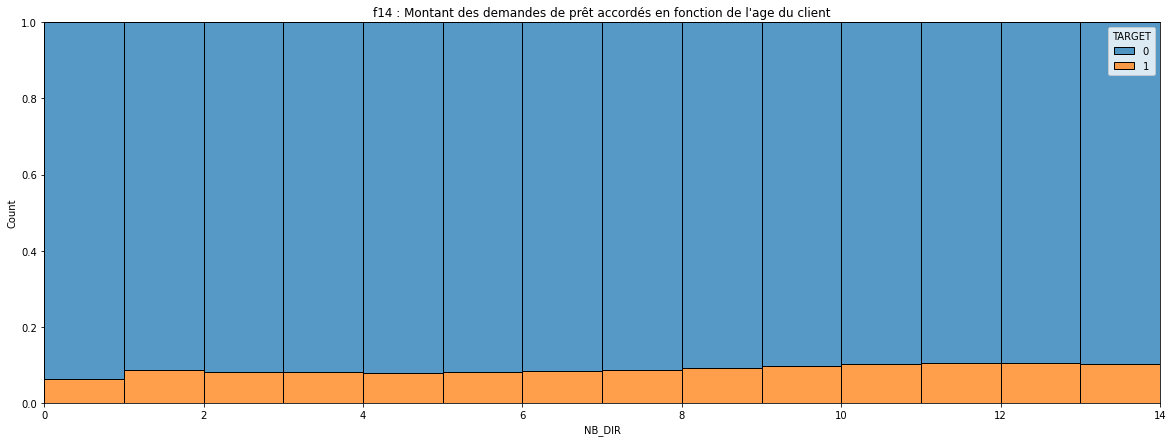

In [136]:
plt.figure(figsize=(20,7))
plt.title("f14 : Montant des demandes de prêt accordés en fonction de l'age du client")
sns.histplot(x = 'NB_DIR',data = application_train,hue='TARGET', multiple="fill",bins=14)
plt.show()

En fonction du nombre de prêt solicité dans le passé, la proportion de défault n'évolue pas significativement.

> <b> Variable : AMT_ANNUITY_SUM

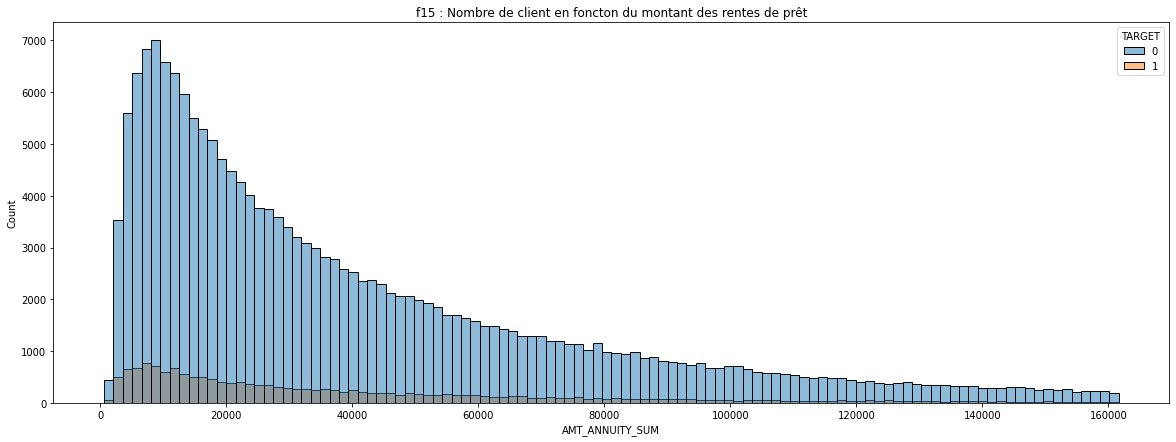

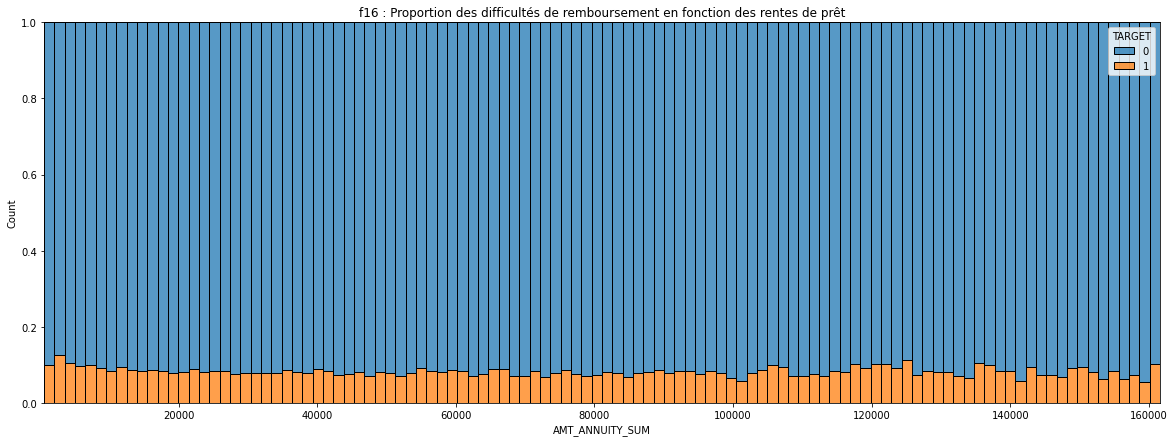

In [173]:
plt.figure(figsize=(20,7))
plt.title("f15 : Nombre de client en foncton du montant des rentes de prêt")
sns.histplot(x = 'AMT_ANNUITY_SUM', 
             data = application_train[application_train.AMT_ANNUITY_SUM>0],
             hue='TARGET')
plt.show()

plt.figure(figsize=(20,7))
plt.title("f16 : Proportion des difficultés de remboursement en fonction des rentes de prêt")
sns.histplot(x = 'AMT_ANNUITY_SUM',data = application_train[application_train.AMT_ANNUITY_SUM>0],hue='TARGET', multiple="fill")
plt.show()

Sur les figures 15 et 16 nous montre les proportion des rentes de prêt. Comme on pourrait s'y attendre les rente de prêt etant proportionnel aux montants des prêts solicités, cette distribution est semble à la distribution de la variable 'AMT_crédit'.

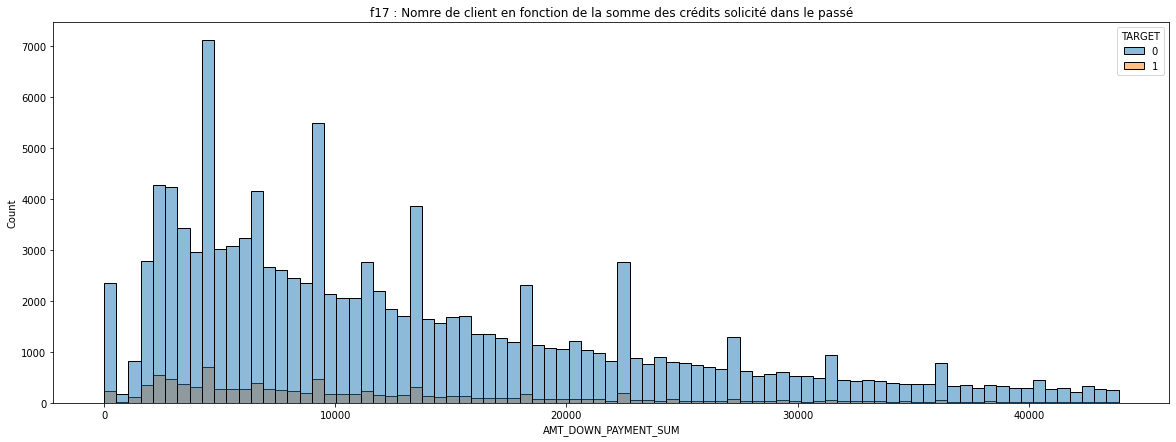

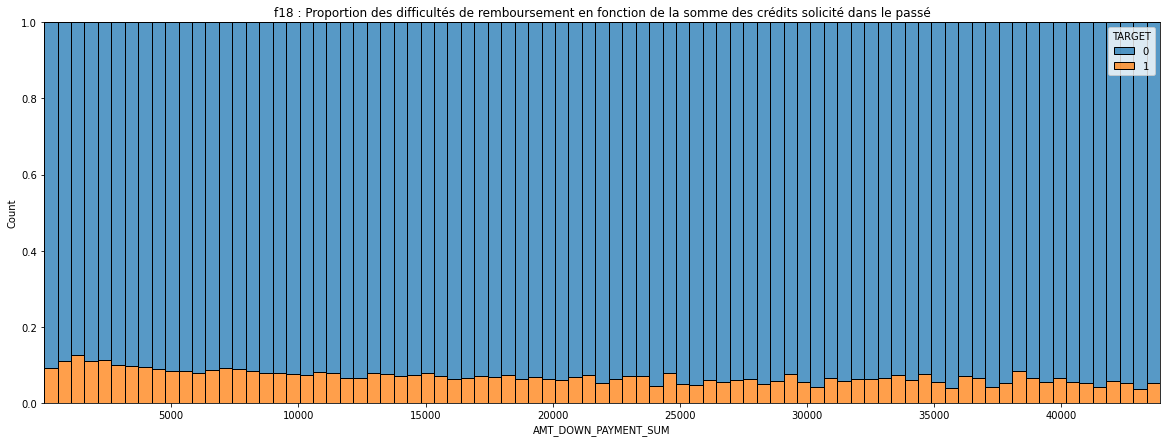

In [174]:
plt.figure(figsize=(20,7))
plt.title("f17 : Nomre de client en fonction de la somme des crédits solicité dans le passé")
sns.histplot(x = 'AMT_DOWN_PAYMENT_SUM', 
             data = application_train[application_train.AMT_DOWN_PAYMENT_SUM>0],
             hue='TARGET')
plt.show()

plt.figure(figsize=(20,7))
plt.title("f18 : Proportion des difficultés de remboursement en fonction de la somme des crédits solicité dans le passé")
sns.histplot(x = 'AMT_DOWN_PAYMENT_SUM',data = application_train[application_train.AMT_DOWN_PAYMENT_SUM>0],
             hue='TARGET', multiple="fill")
plt.show()

Sur les raphique 17 et 18 nous observons la somme des crédits dans le passé. Nous observons un pic pour la valeur 8 000 ce qui signifit le groupe de client le plus grand à avoir solicité des crédit dans le passé est le groupe qui avait solicité au total 8000.

La proportion des difficulté ne varie pas là non plus, ce qui signifie que les capacité de remboursement ne semble pas dépendre de la somme total des prêts contracter dans le passé.

## Observation des corrélations entre variables

Observations des relations entre variables


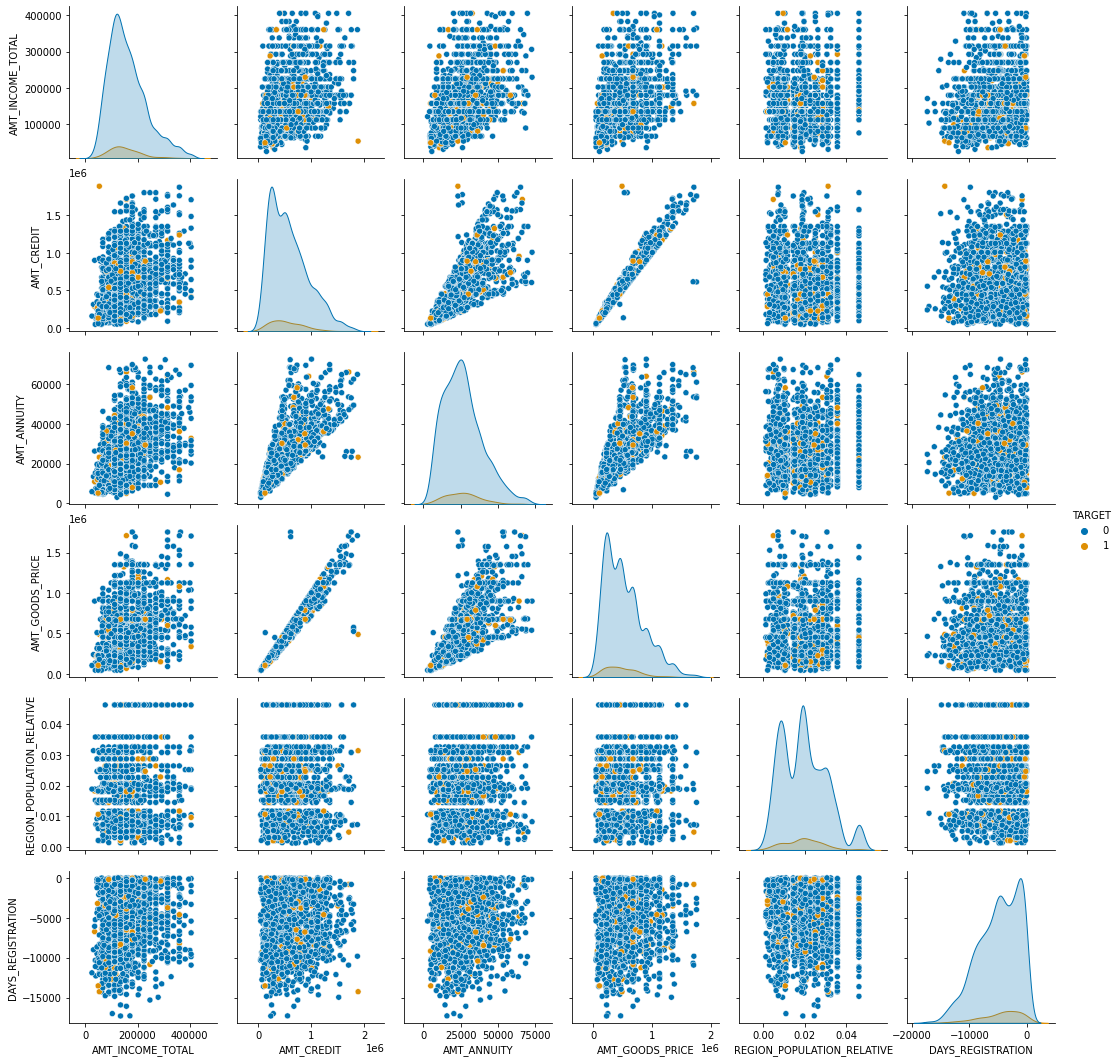

In [26]:
print('Observations des relations entre variables')
index_ = list(application_train.describe(include=[float]).T.index[:6])
index_.append('TARGET')
sns.pairplot(application_train[index_][:2000],
            hue='TARGET',
            palette='colorblind')
plt.show()

Sur ces graphiques nous pouvons observer plusieurs corrélations linéaires entre variables :
- AMT_Good_Price et AMT_credit
- AMT_Anuity et AMT_credit

Cepedant nous n'observons pas de cluster dans la réparton de nos target.

C:\Users\micke\AppData\Local\Temp/ipykernel_13608/4053944234.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return SCE/SCT
C:\Users\micke\AppData\Local\Temp/ipykernel_13608/4053944234.py:8: RuntimeWarning: invalid value encountered in double_scalars
  SCT = sum([(yj-moyenne_y)**2 for yj in y])
C:\Users\micke\AppData\Local\Temp/ipykernel_13608/4053944234.py:9: RuntimeWarning: invalid value encountered in double_scalars
  SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])


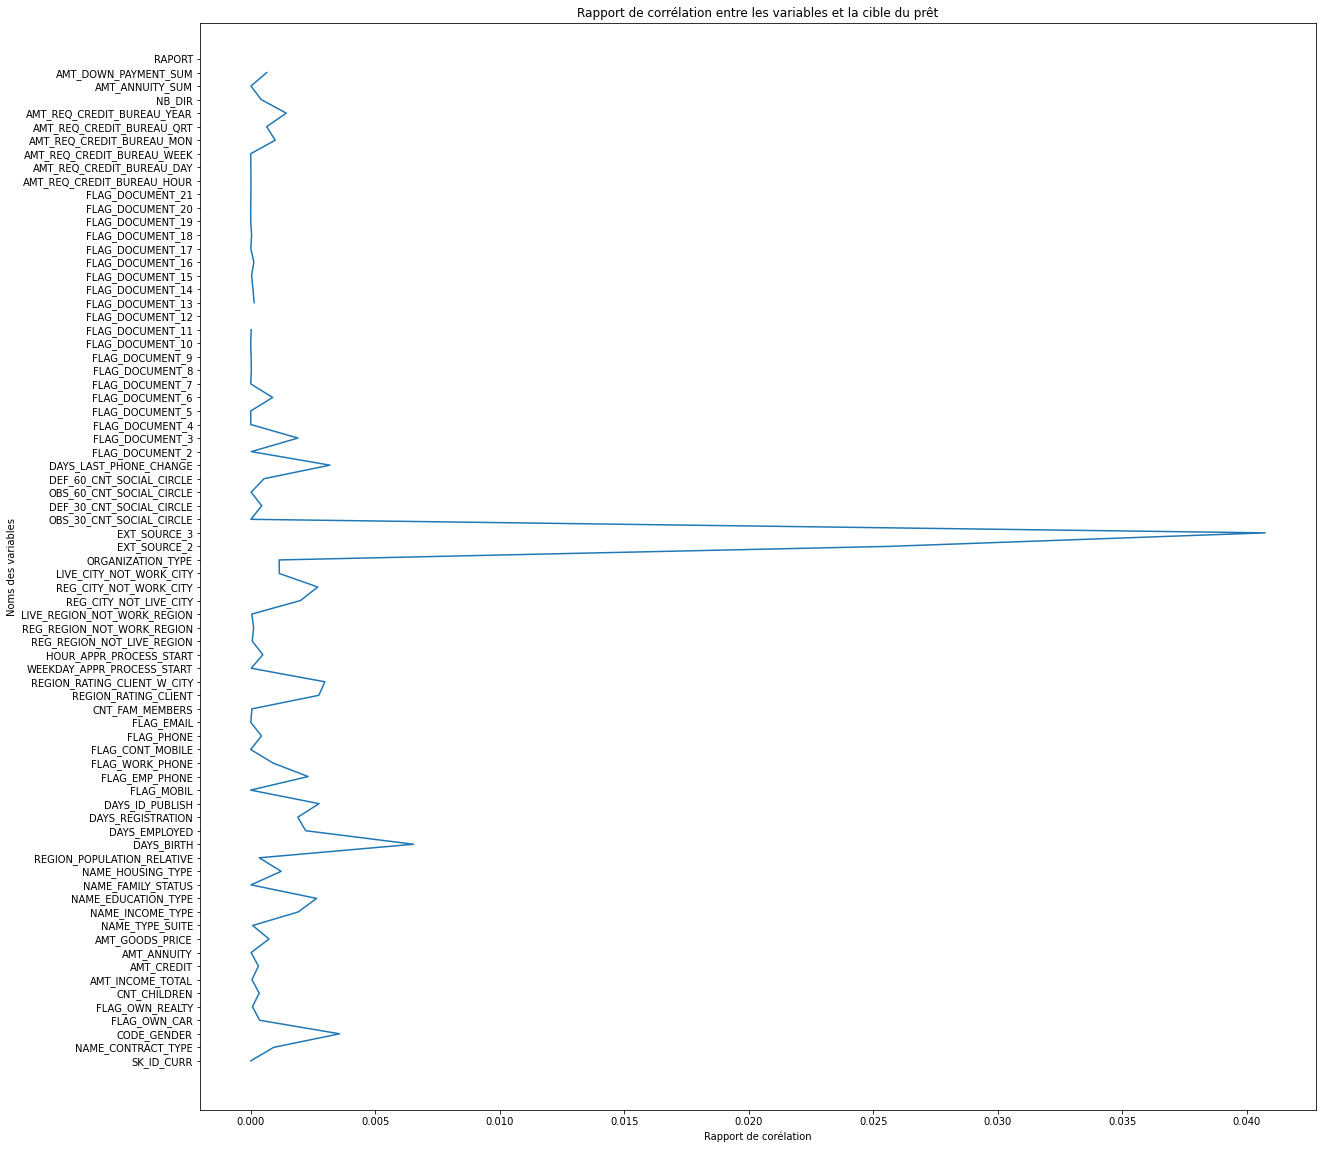

In [80]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

eta_s = []
for u in application_train.drop(['TARGET'], axis=1).columns:
    eta_s.append(eta_squared(application_train.TARGET,application_train[u]))
    
plt.figure(figsize=(20,20))
plt.title('Rapport de corrélation entre les variables et la cible du prêt')
plt.xlabel('Rapport de corélation')
plt.ylabel('Noms des variables')

plt.plot(eta_s,application_train.drop(['TARGET'], axis=1).columns)
plt.show()

Ce graphique nous montre le rapport de corrélation provenant de la métode de l'analyse de la variance (ANOVA).
PLus le rapport est proche de 1 plus la corrélation entre la variable et la target est grande.
Pour l'ensemble des variables observées le rapport de corrélation est faible, inférieur à 0.04.  

## Conclusion

A l'issue de phase d'analyse exploratoire nous avons une vision globale de la répartition de l'ensemble de nos varialbes.
Nous avons vu la répartition de la Target avec un ratio de 92% des individue n'yant aucun problème de remboursement du prêt contre 8% des indivi yant rencontré des difficulté de remboursement.

Nous avons observer le montant des demande de prêt ainsi que la répartion de la target en fonction de l'âge. De manière générale, jusqu'à 54 les personnes avec des difficulté de remboursement avait des demande 5% moins élevé que les autres. 

Nous avons pu observer que cette répartion ne change pas en fonction du genre de l'individu, de sa situation famialle.
Notre analyse nous montre par contre qu'en fonction du type d'emploi la proportion des indivis ayant fait un défault de paiement est la plus élevée pour l'emploi 'Transport de type 4' en effet la répartition s'élève à 18% de défault de remboursement là où la moyenne est de 8%.

En Observant la corélation entre les variable par la méthode ANOVA nous avons pu observer que les variable les plus corréler à la Target sont les variables Ext_source_2 et Ext_source_3, à noté toutefois que le rapport de corélation n'est que de 0.04, pour rappel plus cette valeur se rapproche de 1 plus la corélation entre les variables obsrver est grande.

Par la suite nous développerons un algorrytme s'appuyant sur l'ensemble de notre jeu de données qui sera cappable de prédir la Target tout en fournissant un compte rendu des variables qui ont le plus contribuer à la prise de décision. 

In [39]:
data = application_train
pd.DataFrame.to_csv(data,'data.csv')